<a href="https://colab.research.google.com/github/amitabhdas86/AIML/blob/master/CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

The objective of this experiment is to tune the hyper parameter called momentum and observe the output differences.

We will use CIFAR100 dataset.This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 50,000 training images and 10,000 testing images. 

#### Keywords

* Hyper Parameter
* Momentum
* CIFAR -100
* Xavier intilization
* Pooling
* Cross Entropy Loss
* convolutions

#### Expected time to complete the experiment is : 90min

In [0]:
#@title Experiment Explanation Video
from IPython.display import HTML

HTML("""<video width="800" height="300" controls>
  <source src="https://cdn.talentsprint.com/talentsprint/archives/sc/aiml/aiml_2018_blr_b6/cfus/week_12/module_3_week_12_experiment_3.mp4" type="video/mp4">
</video>
""")

### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P181901560" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "8093344507" #@param {type:"string"}


In [0]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="BLR_M3W12_SAT_EXP_3" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torchvision")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week9/Exp6/config.py")
    ipython.magic("sx wget https://cdn.talentsprint.com/aiml/Experiment_related_data/week9/Exp6/utils.py")
    print ("Setup completed successfully")
   #print ("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "id" : Id, "file_hash" : file_hash, "notebook" : notebook}

      r = requests.post(url, data = data)
      print("Your submission is successful.")
      print("Ref Id:", submission_id)
      print("Date of submission: ", datetime.datetime.now().date().strftime("%d %b %Y"))
      print("Time of submission: ", datetime.datetime.now().time().strftime("%H:%M:%S"))
      print("View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions")
      print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


**Importing required packages**

In [0]:
# Importing pytorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
# Importing config.py file
import config as cf
from utils import *
## Importing python packages
import os
import sys
import time
import datetime
import numpy as np
import math
import matplotlib.pyplot as plt

In [0]:
# Checking for GPU instance
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#Intilizaing the accuracy value as zero
best_acc = 0

#### Preparing the dataset

In [0]:
print('\n[Phase 1] : Data Preparation')

##dataset
dataset = 'cifar100'

# Preparing the dataset
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
]) # meanstd transformation


[Phase 1] : Data Preparation


#### Applying the standard mean

In [0]:
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cf.mean[dataset], cf.std[dataset]),
])

#### Downloading and Loading the dataset

The torchvision package consists of popular datasets, model architectures, and common image transformations for computer vision.


In [0]:
# number of classes in the dataset
num_classes = 100

In [0]:
### Downloading the dataset
trainset = torchvision.datasets.CIFAR100(root='data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='data', train=False, download=False, transform=transform_test)
### Loading the dataset 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=8)


Files already downloaded and verified


#### Let us define the network

In [0]:
import torch.nn as nn
import torch.nn.functional as F

        
class LeNet(nn.Module):
    def __init__(self, num_classes, init_mode='xavier'):  ### supports 'zero', 'normal', 'xavier', 'he' inits
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)
        
        if init_mode == 'zero':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.zero_()   ### fill tensor elements with zeros
                    if m.bias is not None:
                        m.bias.data.zero_()
        
        if init_mode == 'normal':
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    m.weight.data.normal_()   ### fill tensor elements with random numbers from normal distribution
                    if m.bias is not None:
                        m.bias.data.normal_()
        
        if init_mode == 'xavier':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    fan_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                    n = fan_in + fan_out
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in+fan_out))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
        
        if init_mode == 'he':
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                    m.weight.data.normal_(0, math.sqrt(2. / n))
                    if m.bias is not None:
                        m.bias.data.normal_(0, math.sqrt(2. / n))
                if isinstance(m, nn.Linear):
                    size = m.weight.size()
                    fan_out = size[0] # number of rows
                    fan_in = size[1] # number of columns
                    variance = math.sqrt(2.0/(fan_in))
                    m.weight.data.normal_(0.0, variance)
                    if m.bias is not None:
                        m.bias.data.normal_(0, variance)
                
                
    ## Forward Pass
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)

        return(out)

### Training with Xavier init

In [0]:
## Calling the model
net = LeNet(num_classes, init_mode='xavier')
## Checking for GPU instance 
net = net.to(device)

In [0]:
### Intiliazing the loss
criterion = nn.CrossEntropyLoss()

In [0]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    # Declaring the Variables
    train_loss = 0
    correct = 0
    total = 0
    # Loopiing over train data
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # Checking for GPU instance
        #if use_cuda:
        inputs, targets = inputs.to(device), targets.to(device)
        # Optimizer
        optimizer.zero_grad()
        # Converting inputs and targets into pytorch variables
        #inputs, targets = Variable(inputs), Variable(targets)
        # Forward Pass
        outputs = net(inputs)
        # Storing the outputs size
        size_ = outputs.size()
        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Backward Pass
        loss.backward()
        # Optimizer steps
        optimizer.step()
        ## Calculating the traqin loss
        train_loss += loss.item()
        # Predicting the values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the targets size
        total += targets.size(0)
        # Calculating the corrected values
        correct += predicted.eq(targets.data).cpu().sum().item()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(trainloader)-1:
            # Printing the progress bar
            progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Storing number of epoch, loss and accuracy in a file
    train_loss_file.write('%d %.3f %.3f\n' %(epoch, train_loss/len(trainloader), 100.*correct/total))



In [0]:
def test(epoch):
    global best_acc
    net.eval()
    # Declaring the variables
    test_loss = 0
    correct = 0
    total = 0
    # Looping over the test data
    for batch_idx, (inputs, targets) in enumerate(testloader):
        # Checking for GPU instance
        #if use_cuda:
        inputs, targets = inputs.to(device), targets.to(device)
        ## Coverting inputs and targets intp pytorch variables
        #inputs, targets = Variable(inputs, volatile=True), Variable(targets)
        # Forward pass
        outputs = net(inputs)
        # Storing the size of outputs
        size_ = outputs.size()
        # Reducing the dimenssion
        outputs_ = outputs.view(size_[0], num_classes)
        # Calculating the loss
        loss = criterion(outputs_, targets)
        # Calculating the test loss
        test_loss += loss.item()
        # Predicted values
        _, predicted = torch.max(outputs_.data, 1)
        # Storing the size of targets
        total += targets.size(0)
        # Calculating the correct values
        correct += predicted.eq(targets.data).cpu().sum().item()
        # Printing the data
        if batch_idx%30 == 0 or batch_idx == len(testloader)-1:
            # printing the progress bar
            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    # Printing the validation loss 
    print('val_loss: ',  test_loss/len(testloader), 'accuracy: ', 100.0*correct/total)
    # Storing number of epoch,loss and acuracy in a file
    val_loss_file.write('%d %.3f %.3f\n' %(epoch,  test_loss/len(testloader), 100.*correct/total))

    # Save checkpoint.
    acc = 100.*correct/total
    # Checking for best accuracy
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net,
            'acc': acc,
            'epoch': epoch,
        }
        # Checking for the directory
        if not os.path.isdir('../checkpoint'):
            # creating the directory
            os.mkdir('../checkpoint')
        # saving the data
        torch.save(state, '../checkpoint_ckpt.t7')
        # Storing the accuracy value
        best_acc = acc

### Training without momentum

In [0]:
experiment = 'no_momentum'
# Creating files in write mode
train_loss_file = open(experiment+"train_loss.txt", "w")
val_loss_file = open(experiment+"val_loss.txt", "w")

In [0]:
# Optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
# Training and Testing the model for 30 epochs
for epoch in range(0, 30):
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
# Closing the values   
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.602 | Acc: 1.274% (637/50000)   391/391 
 [==================================>] | Loss: 4.569 | Acc: 1.940% (194/10000)   100/100 
val_loss:  4.569071531295776 accuracy:  1.94
Saving..

Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 [==================================>] | Loss: 4.513 | Acc: 3.054% (1527/50000)  391/391 
 [==================================>] | Loss: 4.429 | Acc: 4.390% (439/10000)   100/100 
val_loss:  4.429259648323059 accuracy:  4.39
Saving..

Epoch: 2
 [==================================>] | Loss: 4.357 | Acc: 5.090% (2545/50000)  391/391 
 [==================================>] | Loss: 4.238 | Acc: 6.470% (647/10000)   100/100 
val_loss:  4.237873315811157 accuracy:  6.47
Saving..

Epoch: 3
 [==================================>] | Loss: 4.180 | Acc: 6.692% (3346/50000)  391/391 
 [==================================>] | Loss: 4.076 | Acc: 7.980% (798/10000)  

#### Plotting the Training curves

30 30


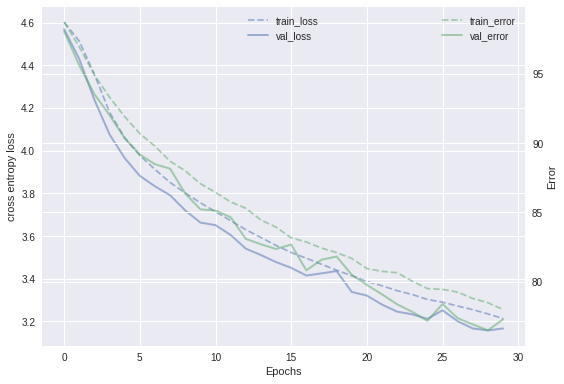

In [0]:
training_curves(experiment)

### Training with momentum

#### Note that momentum is 0 by default in pytorch

In [0]:
best_acc = 0
# Calling the model
net = LeNet(num_classes, init_mode='xavier')
# Checking for GPU instance
net = net.to(device)

In [0]:
experiment = 'with_momentum'
# Cretaing files in write mode
train_loss_file = open(experiment+"train_loss.txt", "w")
val_loss_file = open(experiment+"val_loss.txt", "w")

In [0]:
# Optimizer 
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# Training and Testing the model for 30 epochs
for epoch in range(0, 30):
    # Training the model
    train(epoch)
    # Testing the model
    test(epoch)
# Closing the files
train_loss_file.close()
val_loss_file.close()


Epoch: 0
 [==================================>] | Loss: 4.323 | Acc: 4.498% (2249/50000)  391/391 
 [==================================>] | Loss: 3.953 | Acc: 10.000% (1000/10000) 100/100 
val_loss:  3.95337028503418 accuracy:  10.0
Saving..

Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type LeNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


 [==================================>] | Loss: 3.835 | Acc: 11.198% (5599/50000) 391/391 
 [==================================>] | Loss: 3.619 | Acc: 15.100% (1510/10000) 100/100 
val_loss:  3.6189540457725524 accuracy:  15.1
Saving..

Epoch: 2
 [==================================>] | Loss: 3.612 | Acc: 15.046% (7523/50000) 391/391 
 [==================================>] | Loss: 3.469 | Acc: 17.530% (1753/10000) 100/100 
val_loss:  3.4689165353775024 accuracy:  17.53
Saving..

Epoch: 3
 [==================================>] | Loss: 3.460 | Acc: 17.234% (8617/50000) 391/391 
 [==================================>] | Loss: 3.294 | Acc: 20.650% (2065/10000)

#### Plotting the training curves

In [0]:
training_curves(experiment)

#### Exercise: Compare with momentum rate of 0.99? How does this compare with momentum rate of 0.5?

### Please answer the questions below to complete the experiment:




In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Too Simple, I am wasting time" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "test" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["Yes", "No"]

In [0]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")